In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score


from featexp import get_trend_stats
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from numpy import sort
import lightgbm as lgb
from sklearn.decomposition import PCA

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Load data

In [2]:
# dir_data = "/Users/romulo/Documents/Dataset/Earthquake Damage/"
# #dir_data = "Dataset/"
# df_x_train = pd.read_csv(dir_data+"train_values.csv",index_col="building_id")
# print("df_x_train",df_x_train.shape)
# df_y_train = pd.read_csv(dir_data+"train_labels.csv",index_col="building_id")
# df_x_test = pd.read_csv(dir_data+"test_values.csv",index_col="building_id")
# print("df_x_test",df_x_test.shape)

dir_data = "/Users/rodrigoalmeida/Documents/puc/Semestres/2Semestre/Machine_Learning_POGGY/eartquake/challenge_earthquake/Dataset/"
#dir_data = "Dataset/"
df_x_train = pd.read_csv(dir_data+"labels_risk_area_train.csv",index_col="building_id") 
print("df_x_train",df_x_train.shape)
df_y_train = pd.read_csv(dir_data+"train_labels.csv",index_col="building_id")
df_x_test = pd.read_csv(dir_data+"labels_risk_area_test.csv",index_col="building_id")
print("df_x_test",df_x_test.shape)

#df_x_train = df_x_train[:100]
#df_y_train = df_y_train[:100]
#df_x_test = df_x_test[:100]

data_train = df_x_train.merge(df_y_train, how='left', left_index=True, right_index=True)
print("data_train",data_train.shape)


print("len train:",len(data_train))
print("len train:",len(df_x_test))

df_x_train (234541, 39)
df_x_test (86868, 39)
data_train (234541, 40)
len train: 234541
len train: 86868


## Preparate data

In [3]:
# get y train
y_train = data_train['damage_grade'].values

# remove y of data_train
data_train = data_train.drop('damage_grade', 1)

In [4]:
# let's put the train data and test data together to make get_dummies and then divide
df_x_all = data_train.append(df_x_test)
print("df_x_all:",df_x_all.shape)

# get dummies from cat columns
cat_var = [key for key in dict(df_x_all.dtypes) if dict(df_x_all.dtypes)[key] in ['object'] ]
df_x_all = pd.get_dummies(df_x_all, prefix=cat_var, columns=cat_var)

#divide x_train and x_test
x_train = df_x_all.iloc[:len(data_train)]
x_test = df_x_all.iloc[len(data_train):]

print("x_train:",x_train.shape)
print("x_test:",x_test.shape)

df_x_all: (321409, 39)
x_train: (234541, 69)
x_test: (86868, 69)


In [5]:
x_train.shape

(234541, 69)

In [6]:
x_test.shape

(86868, 69)

In [7]:
# clear memory
del df_x_all,df_x_train,df_y_train,data_train,df_x_test

In [8]:
#get x_dev and y_dev (10% from train)
x_train, x_dev, y_train, y_dev = train_test_split( x_train, y_train, test_size=0.1, random_state=44,shuffle=True)

y_train = np.array([x-1 for x in y_train])
y_dev = np.array([x-1 for x in y_dev])

In [9]:
print("len x_train : %d  len y_train: %d " %(len(x_train),len(y_train)) )
#print("len x_dev   : %d  len y_dev  : %d " %(len(x_dev),len(y_dev)) )
print("len x_test  : %d" %(len(x_test)) )

len x_train : 211086  len y_train: 211086 
len x_test  : 86868


1    120120
2     70516
0     20450
Name: y_train, dtype: int64


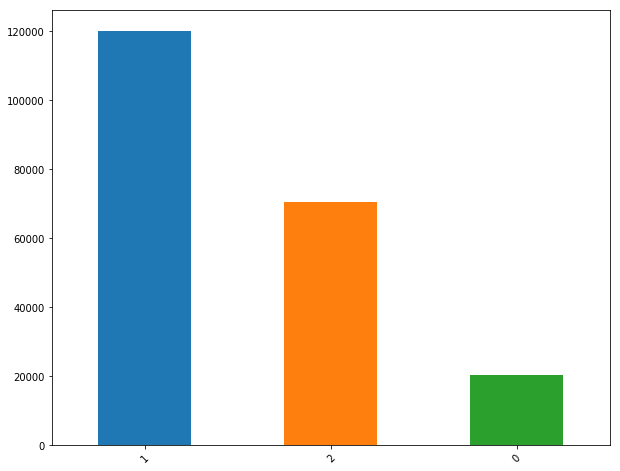

In [10]:
d = {'y_train': y_train}
df_y_train = pd.DataFrame(d)
print(df_y_train["y_train"].value_counts())
df_y_train["y_train"].value_counts().plot.bar( figsize = (10, 8), rot=45 )

## Features

In [11]:
x_all = x_train.append(x_dev)
y_all = np.concatenate((y_train, y_dev))

## Testing

In [12]:
d_train = lgb.Dataset(x_train, label=y_train)

In [13]:
d_val = lgb.Dataset(x_dev, label=y_dev)

In [ ]:
params = {}
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 25
params['min_data'] = 30
params['max_depth'] = 10
params['num_class'] = 3
clf = lgb.train(params, d_train, 8000,valid_sets=[d_val])

In [ ]:
pred_dev =  clf.predict(x_dev)
pred_dev = np.argmax(pred_dev,axis=1)
accuracy_dev = accuracy_score(y_dev, pred_dev)
accuracy_dev

In [ ]:
print(classification_report(y_dev, pred_dev))

In [ ]:
#0.74498292467672
#0.74705498637811
#0.74812938874179
#0.74820613176777
#0.74759218755995
#0.74621081309236

## TIME TO PREDICT AND SUBMIT

In [ ]:
predictions = clf.predict(x_test)

predictions = np.argmax(predictions,axis=1)
predictions = [x+1 for x in predictions]

In [ ]:
submission_format = pd.read_csv(dir_data + 'submission_format.csv', index_col='building_id')

In [ ]:
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.to_csv('2_new_all_lightgbm_submission.csv')